In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

In [4]:
pip uninstall scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install scikit-learn==1.2.2

  Obtaining dependency information for scikit-learn==1.2.2 from https://files.pythonhosted.org/packages/db/98/169b46a84b48f92df2b5e163fce75d471f4df933f8b3d925a61133210776/scikit_learn-1.2.2-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl (8.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
data=pd.read_csv("online_shoppers_intention.csv")

In [3]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [4]:
data.shape


(12330, 18)

In [5]:
print(data.duplicated().sum())


125


In [6]:
data=data.drop_duplicates()

In [7]:
data.shape

(12205, 18)

In [8]:
numerical_columns=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend','Revenue']

In [9]:
data['Revenue'].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [10]:
data['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: count, dtype: int64

In [11]:
data['Weekend'].value_counts()

Weekend
False    9346
True     2859
Name: count, dtype: int64

In [12]:
# IQR function 
def IQR(x):
    x = x.astype(np.float32)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    bb = q1 - 1.5*(q3 - q1)
    ba = q3 + 1.5*(q3 - q1)
    outlier_indices = list(x.index[(x < bb) | (x > ba)])
    outlier_values = list(x[outlier_indices])
    return len(outlier_indices)

In [13]:
total_outliers=0
for i in numerical_columns:
    print(f'Number of IQR outliers {i}: {IQR(data[i])}')

Number of IQR outliers Administrative: 404
Number of IQR outliers Administrative_Duration: 1149
Number of IQR outliers Informational: 2631
Number of IQR outliers Informational_Duration: 2405
Number of IQR outliers ProductRelated: 1007
Number of IQR outliers ProductRelated_Duration: 951
Number of IQR outliers BounceRates: 1428
Number of IQR outliers ExitRates: 1325
Number of IQR outliers PageValues: 2730
Number of IQR outliers SpecialDay: 1249


In [14]:
total_outliers = 0
total_data_points = 0

for i in numerical_columns:
    outliers = IQR(data[i])
    total_outliers += outliers
    total_data_points += len(data[i])

total_outlier_percentage = (total_outliers / total_data_points) * 100

print(f'Total outlier percentage: {total_outlier_percentage:.2f}%')

Total outlier percentage: 12.52%


In [15]:
class AddNewVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['Administrative_Duration_Page'] = X['Administrative_Duration']/data['Administrative']
        X['Informational_Duration_Page'] = X['Informational_Duration']/data['Informational']
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration']/data['ProductRelated']
        
        # division by zero becomes zero
        X['Administrative_Duration_Page'] = X['Administrative_Duration_Page'].fillna(0)
        X['Informational_Duration_Page'] = X['Informational_Duration_Page'].fillna(0)
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration_Page'].fillna(0)
     
        return X


In [16]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns_to_drop)

In [17]:
X = data.drop(['Revenue'], axis = 1)
y = data['Revenue']

In [18]:
y

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12205, dtype: bool

In [19]:
X.shape

(12205, 17)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
pipe = Pipeline([
    ('add_new_vars', AddNewVariables()),
    ('drop_old_vars', DropVariables(columns_to_drop=['Administrative', 'Informational', 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']))  
])

In [22]:
pipe1 = clone(pipe)

In [23]:
x_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
6484,2,165.200000,0,0.00,36,983.425000,0.000000,0.010526,0.000000,0.0,Aug,2,4,8,6,New_Visitor,True
114,0,0.000000,1,93.00,30,1045.833333,0.012903,0.035484,0.000000,0.2,Feb,1,1,1,3,Returning_Visitor,False
5405,0,0.000000,0,0.00,24,324.000000,0.104167,0.131944,0.000000,0.6,May,3,2,6,13,Returning_Visitor,False
4781,4,88.628571,0,0.00,39,659.935714,0.000000,0.019560,0.000000,0.0,May,2,2,3,1,Returning_Visitor,False
2953,0,0.000000,0,0.00,53,2309.995238,0.047479,0.063948,0.000000,0.4,May,3,2,1,3,Returning_Visitor,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0,0.000000,0,0.00,6,60.250000,0.033333,0.066667,0.000000,0.0,Nov,2,2,7,3,Returning_Visitor,False
5272,6,79.500000,1,19.00,11,314.250000,0.000000,0.003333,0.000000,0.0,May,2,2,1,2,New_Visitor,True
5475,2,79.600000,3,332.08,34,1011.016667,0.018919,0.043243,5.128358,0.0,Oct,2,2,7,1,Returning_Visitor,False
874,3,64.500000,0,0.00,35,1334.551371,0.000000,0.007310,0.000000,0.0,Mar,3,2,4,2,Returning_Visitor,True


In [24]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [25]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
6484,0.000000,0.010526,0.000000,0.0,Aug,2,4,8,6,New_Visitor,True,82.600000,0.000000,27.317361
114,0.012903,0.035484,0.000000,0.2,Feb,1,1,1,3,Returning_Visitor,False,0.000000,93.000000,34.861111
5405,0.104167,0.131944,0.000000,0.6,May,3,2,6,13,Returning_Visitor,False,0.000000,0.000000,13.500000
4781,0.000000,0.019560,0.000000,0.0,May,2,2,3,1,Returning_Visitor,False,22.157143,0.000000,16.921429
2953,0.047479,0.063948,0.000000,0.4,May,3,2,1,3,Returning_Visitor,False,0.000000,0.000000,43.584816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.033333,0.066667,0.000000,0.0,Nov,2,2,7,3,Returning_Visitor,False,0.000000,0.000000,10.041667
5272,0.000000,0.003333,0.000000,0.0,May,2,2,1,2,New_Visitor,True,13.250000,19.000000,28.568182
5475,0.018919,0.043243,5.128358,0.0,Oct,2,2,7,1,Returning_Visitor,False,39.800000,110.693333,29.735784
874,0.000000,0.007310,0.000000,0.0,Mar,3,2,4,2,Returning_Visitor,True,21.500000,0.000000,38.130039


In [26]:
y_train=LabelEncoder().fit_transform(y_train)
y_test=LabelEncoder().fit_transform(y_test)

In [27]:
y_train

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [28]:
#true-1 false-0

X_train['Weekend'] = LabelEncoder().fit_transform(X_train['Weekend'])
     

# label encoding for Month
mapping_month = {'Jan' : 1, 'Feb' : 2,
                 'Mar' : 3, 'Apr' : 4,
                 'May' : 5, 'June' : 6,
                 'Jul' : 7, 'Aug' : 8,
                 'Sep' : 9, 'Oct' : 10,
                 'Nov' : 11, 'Dec' : 12}

X_train['Month'] = X_train['Month'].map(mapping_month)

X_test['Weekend'] = LabelEncoder().fit_transform(X_test['Weekend'])
     

# label encoding for Month
mapping_month = {'Jan' : 1, 'Feb' : 2,
                 'Mar' : 3, 'Apr' : 4,
                 'May' : 5, 'June' : 6,
                 'Jul' : 7, 'Aug' : 8,
                 'Sep' : 9, 'Oct' : 10,
                 'Nov' : 11, 'Dec' : 12}

X_test['Month'] = X_test['Month'].map(mapping_month)

In [29]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
6484,0.000000,0.010526,0.000000,0.0,8,2,4,8,6,New_Visitor,1,82.600000,0.000000,27.317361
114,0.012903,0.035484,0.000000,0.2,2,1,1,1,3,Returning_Visitor,0,0.000000,93.000000,34.861111
5405,0.104167,0.131944,0.000000,0.6,5,3,2,6,13,Returning_Visitor,0,0.000000,0.000000,13.500000
4781,0.000000,0.019560,0.000000,0.0,5,2,2,3,1,Returning_Visitor,0,22.157143,0.000000,16.921429
2953,0.047479,0.063948,0.000000,0.4,5,3,2,1,3,Returning_Visitor,0,0.000000,0.000000,43.584816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.033333,0.066667,0.000000,0.0,11,2,2,7,3,Returning_Visitor,0,0.000000,0.000000,10.041667
5272,0.000000,0.003333,0.000000,0.0,5,2,2,1,2,New_Visitor,1,13.250000,19.000000,28.568182
5475,0.018919,0.043243,5.128358,0.0,10,2,2,7,1,Returning_Visitor,0,39.800000,110.693333,29.735784
874,0.000000,0.007310,0.000000,0.0,3,3,2,4,2,Returning_Visitor,1,21.500000,0.000000,38.130039


In [30]:
one_hot_encoded_data =pd.get_dummies(X_train['VisitorType'],prefix="VType")
X_train = X_train.join(one_hot_encoded_data)
X_train = X_train.drop(['VisitorType'], axis = 1)

one_hot_encoded_data =pd.get_dummies(X_test['VisitorType'],prefix="VType")
X_test = X_test.join(one_hot_encoded_data)
X_test = X_test.drop(['VisitorType'], axis = 1)

In [31]:
X_train['VType_New_Visitor'] = LabelEncoder().fit_transform(X_train['VType_New_Visitor'])
X_train['VType_Other'] = LabelEncoder().fit_transform(X_train['VType_Other'])
X_train['VType_Returning_Visitor'] = LabelEncoder().fit_transform(X_train['VType_Returning_Visitor'])


X_test['VType_New_Visitor'] = LabelEncoder().fit_transform(X_test['VType_New_Visitor'])
X_test['VType_Other'] = LabelEncoder().fit_transform(X_test['VType_Other'])
X_test['VType_Returning_Visitor'] = LabelEncoder().fit_transform(X_test['VType_Returning_Visitor'])


In [32]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page,VType_New_Visitor,VType_Other,VType_Returning_Visitor
6484,0.000000,0.010526,0.000000,0.0,8,2,4,8,6,1,82.600000,0.000000,27.317361,1,0,0
114,0.012903,0.035484,0.000000,0.2,2,1,1,1,3,0,0.000000,93.000000,34.861111,0,0,1
5405,0.104167,0.131944,0.000000,0.6,5,3,2,6,13,0,0.000000,0.000000,13.500000,0,0,1
4781,0.000000,0.019560,0.000000,0.0,5,2,2,3,1,0,22.157143,0.000000,16.921429,0,0,1
2953,0.047479,0.063948,0.000000,0.4,5,3,2,1,3,0,0.000000,0.000000,43.584816,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.033333,0.066667,0.000000,0.0,11,2,2,7,3,0,0.000000,0.000000,10.041667,0,0,1
5272,0.000000,0.003333,0.000000,0.0,5,2,2,1,2,1,13.250000,19.000000,28.568182,1,0,0
5475,0.018919,0.043243,5.128358,0.0,10,2,2,7,1,0,39.800000,110.693333,29.735784,0,0,1
874,0.000000,0.007310,0.000000,0.0,3,3,2,4,2,1,21.500000,0.000000,38.130039,0,0,1


In [33]:
numerical_columns=['Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [34]:
X_train_numerical = X_train[numerical_columns]
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_train[numerical_columns] = X_train_numerical_scaled


X_test_numerical = X_test[numerical_columns]
scaler = StandardScaler()
X_test_numerical_scaled = scaler.fit_transform(X_test_numerical)
X_test[numerical_columns] = X_test_numerical_scaled

In [35]:
X_train

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page,VType_New_Visitor,VType_Other,VType_Returning_Visitor
6484,-0.450146,-0.668028,-0.316039,-0.305268,8,2,4,8,6,1,1.328256,-0.226997,-0.234116,1,0,0
114,-0.163339,-0.126884,-0.316039,0.707117,2,1,1,1,3,0,-0.441439,1.194434,-0.066468,0,0,1
5405,1.865227,1.964628,-0.316039,2.731888,5,3,2,6,13,0,-0.441439,-0.226997,-0.541185,0,0,1
4781,-0.450146,-0.472165,-0.316039,-0.305268,5,2,2,3,1,0,0.033275,-0.226997,-0.465149,0,0,1
2953,0.605207,0.490281,-0.316039,1.719503,5,3,2,1,3,0,-0.441439,-0.226997,0.127402,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,0.290773,0.549239,-0.316039,-0.305268,11,2,2,7,3,0,-0.441439,-0.226997,-0.618041,0,0,1
5272,-0.450146,-0.823990,-0.316039,-0.305268,5,2,2,1,2,1,-0.157559,0.063403,-0.206319,1,0,0
5475,-0.029624,0.041359,-0.048306,-0.305268,10,2,2,7,1,0,0.411271,1.464863,-0.180371,0,0,1
874,-0.450146,-0.737775,-0.316039,-0.305268,3,3,2,4,2,1,0.019196,-0.226997,0.006178,0,0,1


In [36]:
X_train.shape

(8543, 16)

In [37]:
smt=SMOTE()
X_train_smote,y_train_smote=smt.fit_resample(X_train,y_train)

In [38]:
y_train_smote.shape

(14362,)

In [39]:
print('AFTER oversampling (smote)')
print(pd.Series(y_train_smote).value_counts())

AFTER oversampling (smote)
0    7181
1    7181
Name: count, dtype: int64


# EDA

In [289]:
X_train.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page', 'VType_New_Visitor', 'VType_Other',
       'VType_Returning_Visitor'],
      dtype='object')

In [48]:
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VType_New_Visitor','VType_Other','VType_Returning_Visitor','Weekend']

Text(0.5, 1.0, 'Correlation Heatmap')

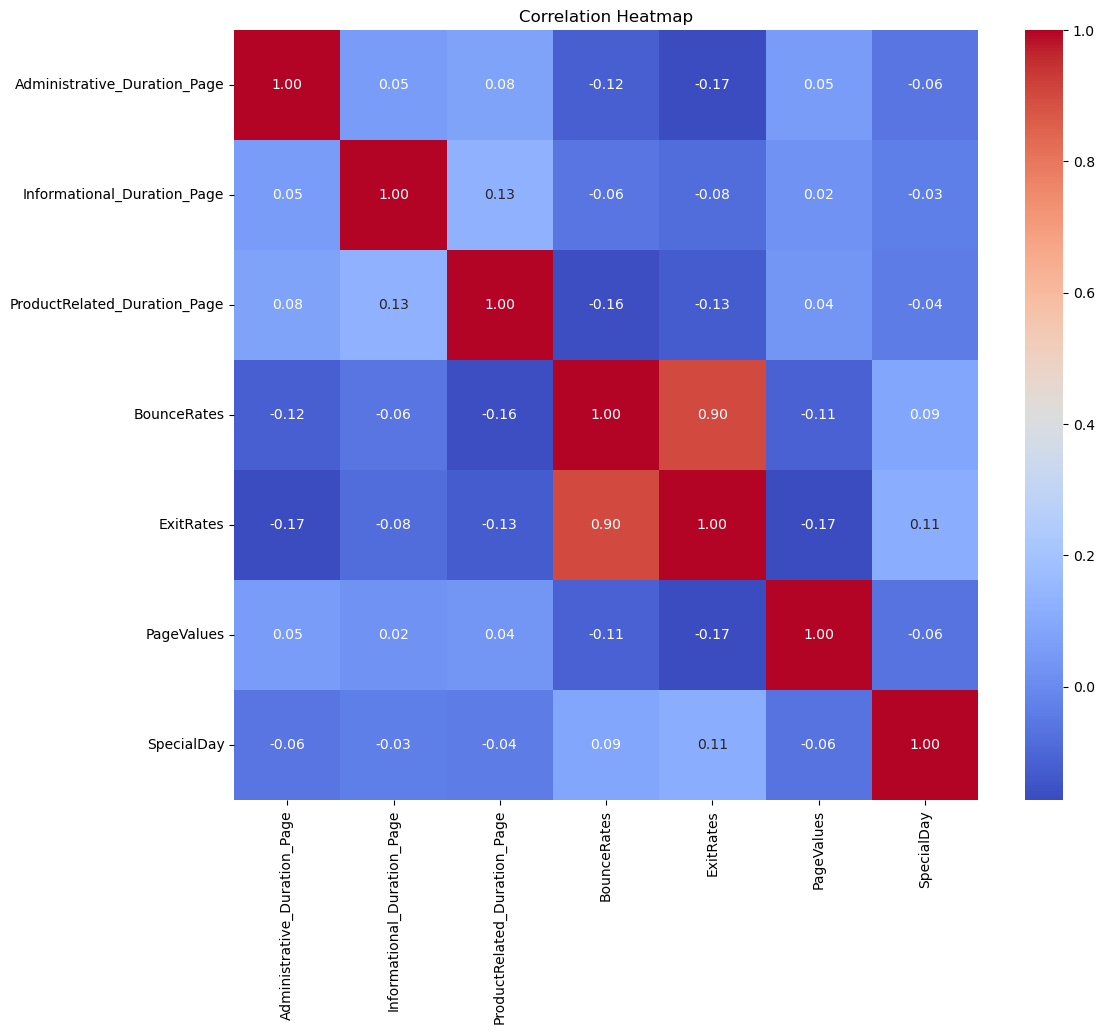

In [49]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [50]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train[column], y_train)
    print('')

p-value: 1.6351464585069558e-52
Reject H0, feature Month is dependent with Revenue

p-value: 1.0908594134349057e-08
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 0.007700184985415064
Reject H0, feature Browser is dependent with Revenue

p-value: 0.7276408547218776
Accept H0, feature Region is independent with Revenue

p-value: 1.7604246936686518e-42
Reject H0, feature TrafficType is dependent with Revenue

p-value: 2.3212741382161994e-21
Reject H0, feature VType_New_Visitor is dependent with Revenue

p-value: 0.9733241469555696
Accept H0, feature VType_Other is independent with Revenue

p-value: 8.81727274938809e-21
Reject H0, feature VType_Returning_Visitor is dependent with Revenue

p-value: 0.05252649771069415
Accept H0, feature Weekend is independent with Revenue



<Axes: ylabel='SpecialDay'>

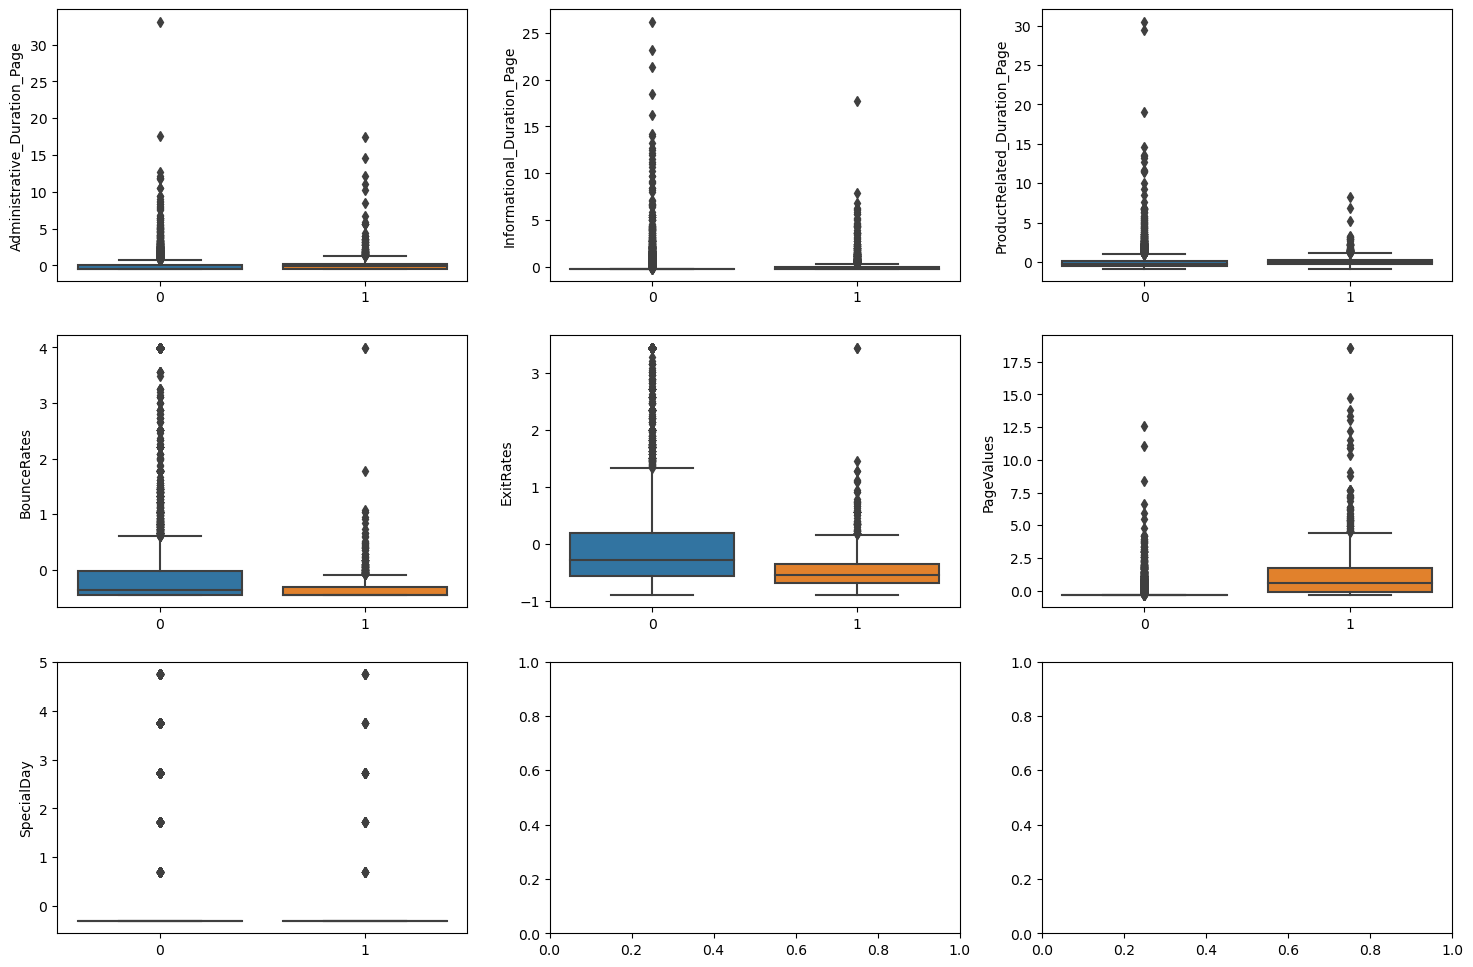

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train, y=X_train['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train, y=X_train['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train, y=X_train['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train, y=X_train['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train, y=X_train['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train, y=X_train['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train, y=X_train['SpecialDay'])



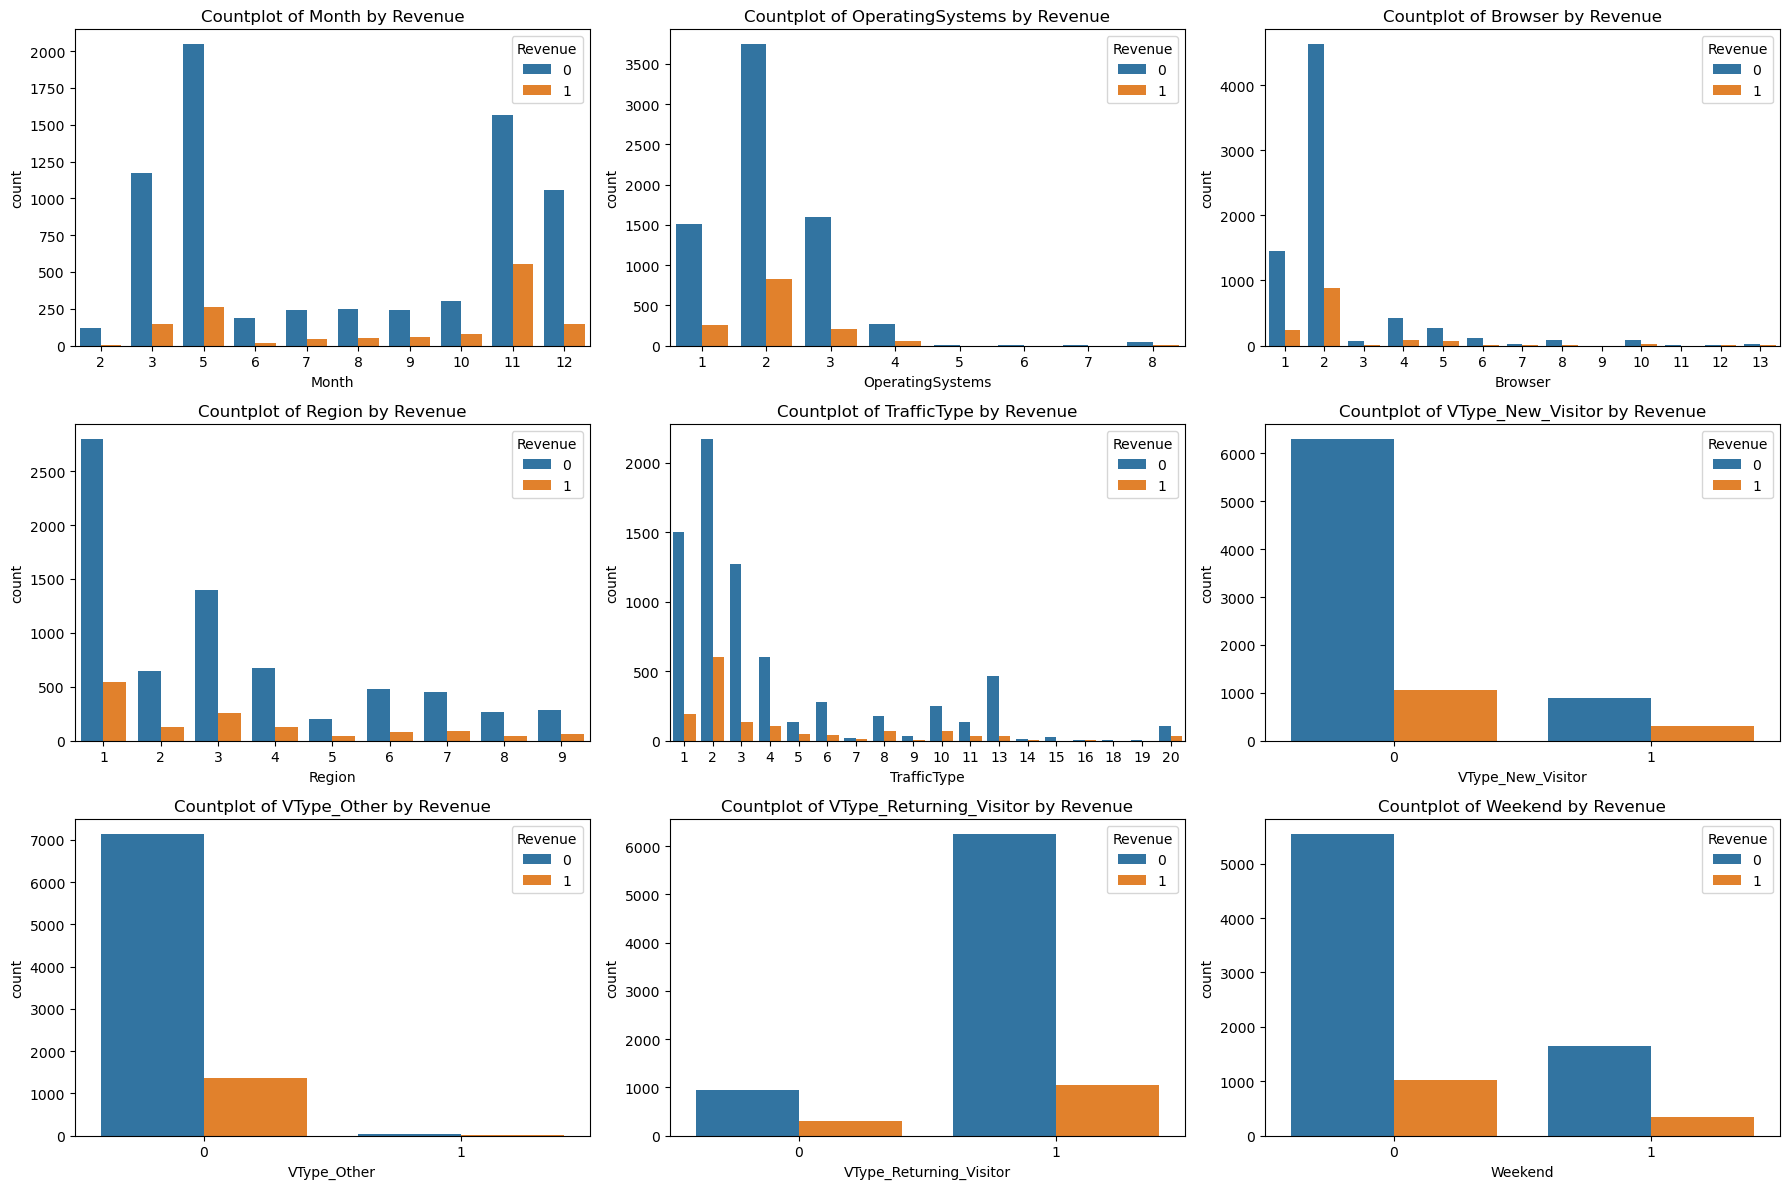

In [52]:
ig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each categorical column and create a countplot in each subplot
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue=y_train, data=X_train, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
        

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

# after SMOTE


Text(0.5, 1.0, 'Correlation Heatmap')

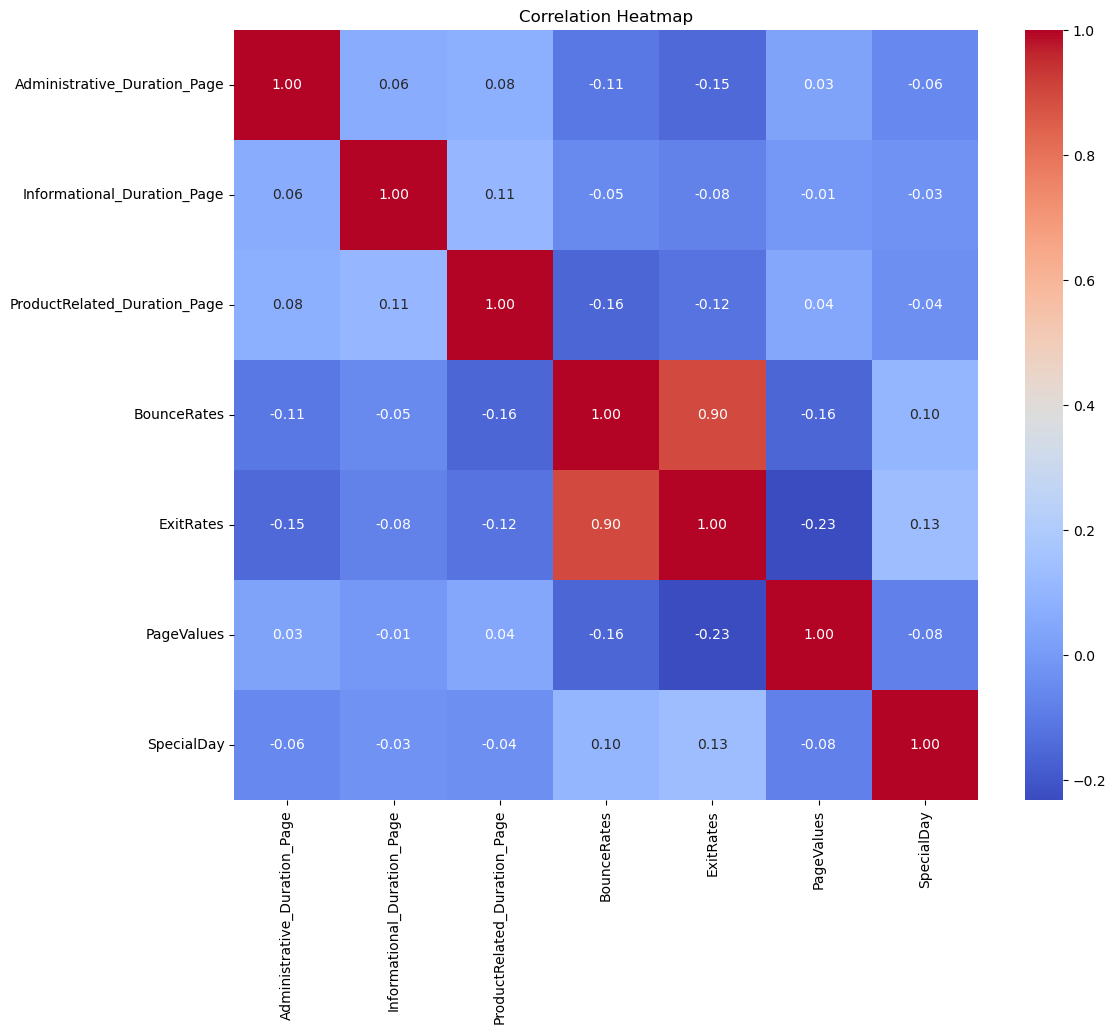

In [53]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train_smote[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [54]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train_smote[column], y_train_smote)
    print('')

p-value: 5.303035575774066e-262
Reject H0, feature Month is dependent with Revenue

p-value: 2.567534961928342e-94
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 3.438937423079586e-15
Reject H0, feature Browser is dependent with Revenue

p-value: 3.312429831305457e-11
Reject H0, feature Region is dependent with Revenue

p-value: 5.630718650538669e-183
Reject H0, feature TrafficType is dependent with Revenue

p-value: 3.1625343647392484e-06
Reject H0, feature VType_New_Visitor is dependent with Revenue

p-value: 0.6009994971680879
Accept H0, feature VType_Other is independent with Revenue

p-value: 8.785050314912667e-98
Reject H0, feature VType_Returning_Visitor is dependent with Revenue

p-value: 3.2977895793687217e-43
Reject H0, feature Weekend is dependent with Revenue



<Axes: ylabel='SpecialDay'>

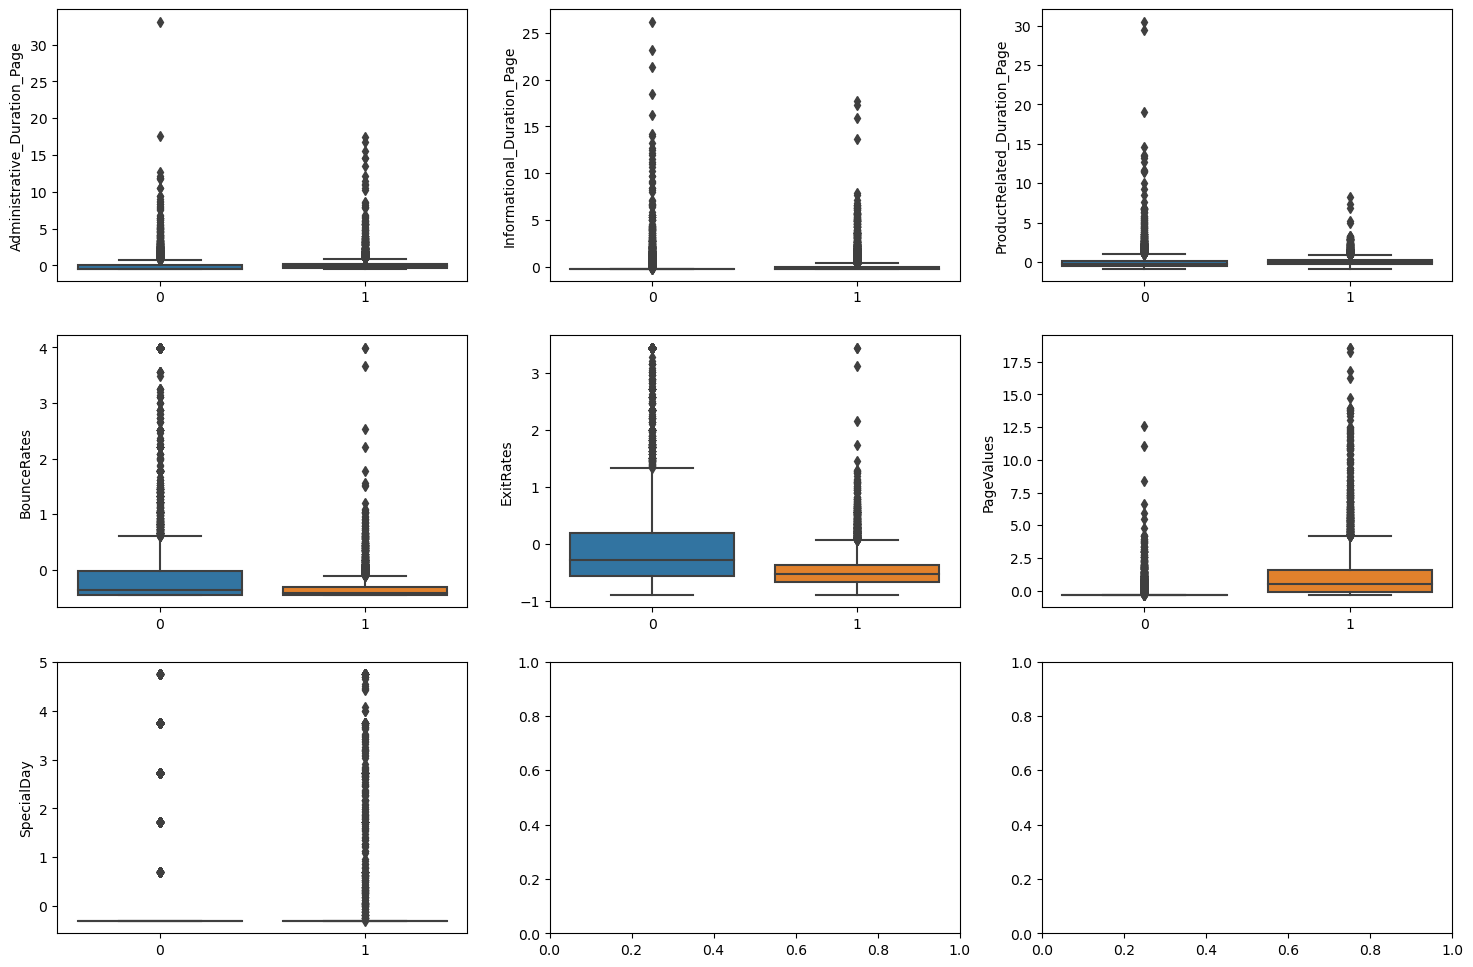

In [55]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train_smote, y=X_train_smote['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train_smote, y=X_train_smote['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train_smote, y=X_train_smote['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train_smote, y=X_train_smote['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train_smote, y=X_train_smote['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train_smote, y=X_train_smote['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train_smote, y=X_train_smote['SpecialDay'])



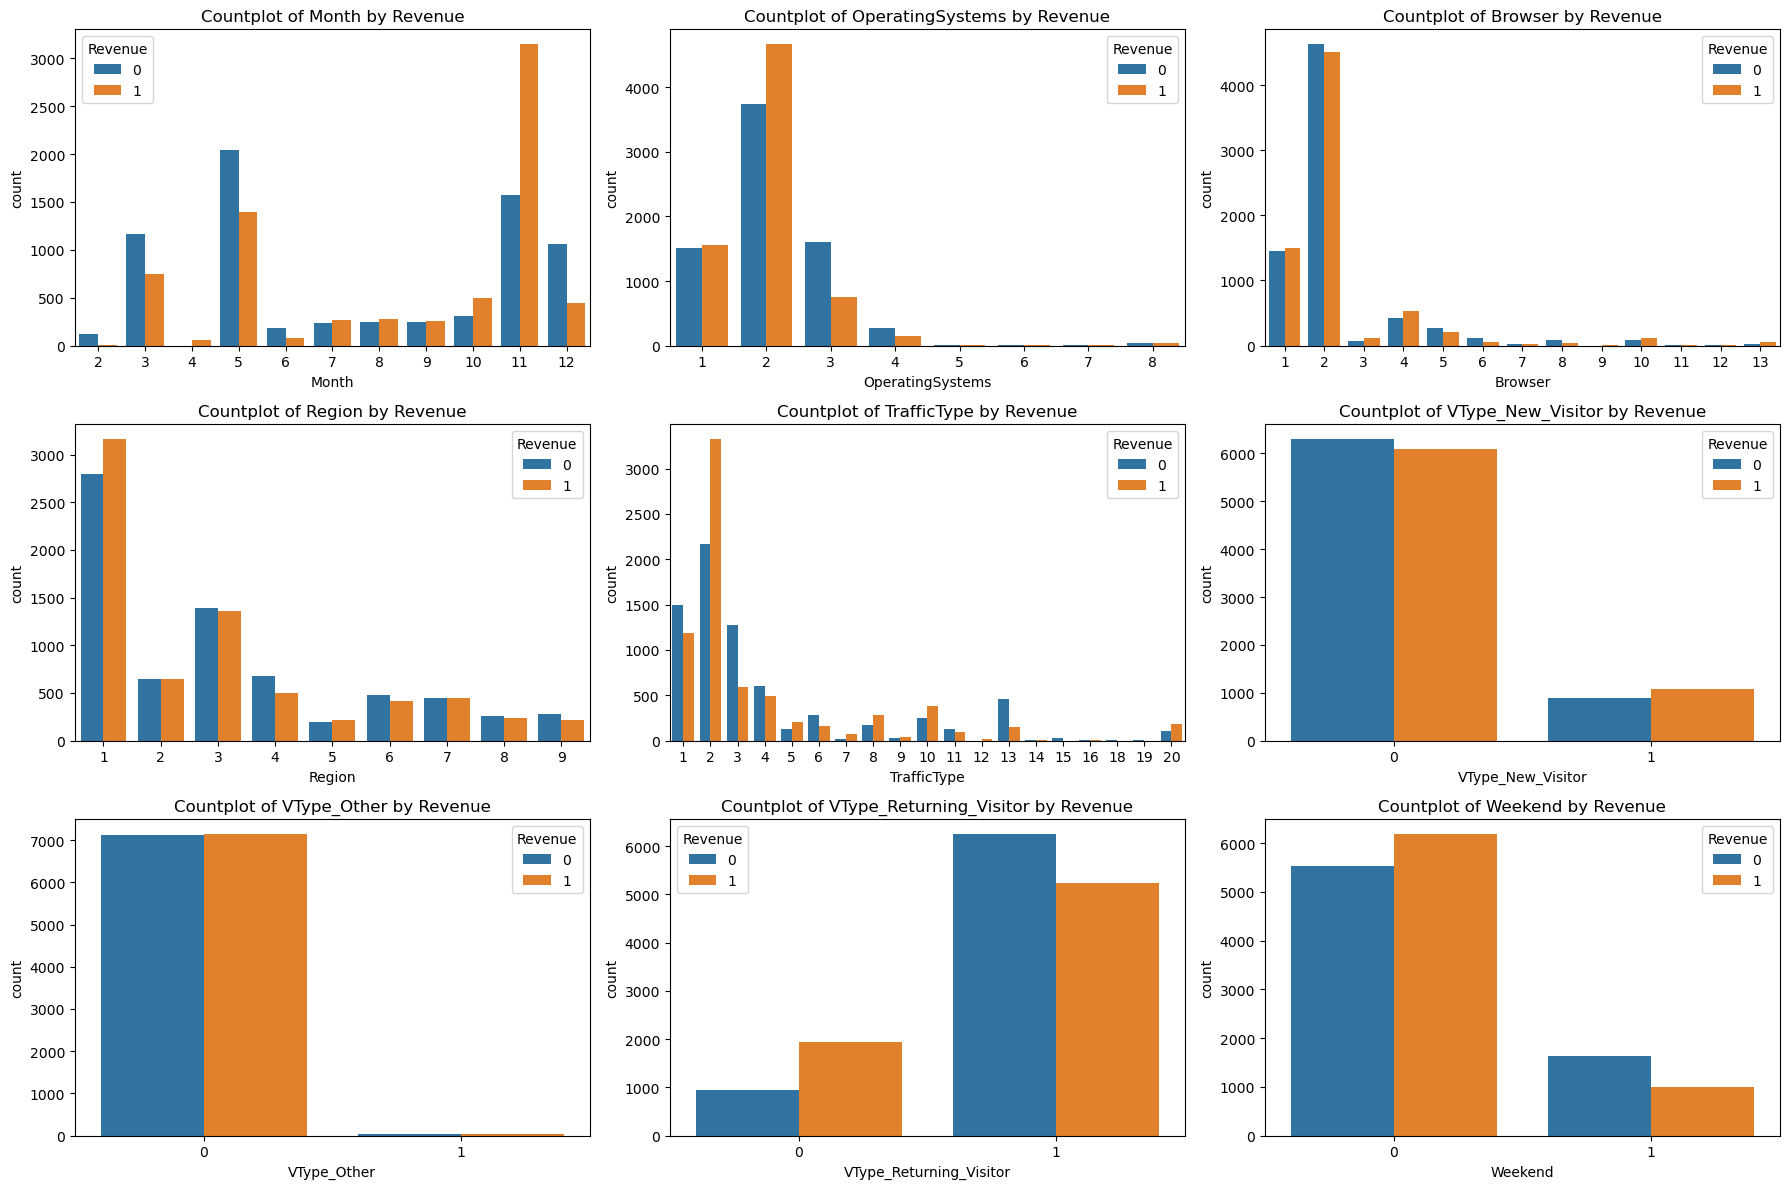

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each categorical column and create a countplot in each subplot
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue=y_train_smote, data=X_train_smote, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
    
    

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

# clustering


In [712]:
import prince
import pprint

In [736]:
famd = prince.FAMD(
    n_components=5,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn', 
    random_state=42)

In [737]:
famd = famd.fit(X_train_smote)

In [738]:
famd.row_coordinates(X_train_smote)

component,0,1,2,3,4
0,0.351040,5.209609,-5.504500,0.909540,3.876573
1,-0.983382,0.487888,8.175330,-0.578755,2.172121
2,-1.290725,-4.759709,-0.547639,-0.129747,4.109141
3,-1.033404,-3.090087,-0.769200,-0.172596,0.947552
4,-1.112784,-3.104502,0.793960,-0.221013,2.771214
...,...,...,...,...,...
14357,0.644573,5.042226,-4.637222,-0.209269,-1.537907
14358,-0.792710,-2.211663,-0.798055,-0.047724,-2.597270
14359,0.449890,7.607140,1.373720,0.591961,5.508164
14360,-0.738293,0.435336,2.349579,-0.281875,-2.195929


In [739]:
ax = famd.plot_row_coordinates(
...     X_train_smote,
...     ax=None,
...     figsize=(6, 6),
...     x_component=0,
...     y_component=1,
...     labels=X.index,
...     #color_labels=['Oak type {}'.format(t) for t in X['Oak type']],
...     ellipse_outline=False,
...     ellipse_fill=True,
...     show_points=True
... )

AttributeError: 'FAMD' object has no attribute 'plot_row_coordinates'

In [735]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,14.225,5.22%,5.22%
1,9.896,3.63%,8.85%
2,8.488,3.11%,11.97%
3,7.058,2.59%,14.56%
4,6.894,2.53%,17.09%


In [722]:
famd.row_coordinates(X_train_smote).head()

component,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.351061,5.210960,-5.499186,0.919140,3.986222,-0.509420,2.569637,3.913422,-0.343913,-3.785292,...,-1.016370,4.588410,-2.250298,-6.535154,-1.935534,0.266830,-1.624027,2.071126,-5.181049,0.134084
1,-0.983384,0.490593,8.178999,-0.624643,2.129270,-4.373017,-2.511880,1.435479,-1.293835,-4.853841,...,-6.035191,2.926056,0.009925,2.889386,0.313493,-0.449892,0.328035,3.002332,2.101713,3.966544
2,-1.290742,-4.759905,-0.546610,-0.140956,4.077935,6.695509,-3.221440,0.292398,1.342970,0.681926,...,2.764191,1.910742,-1.131459,0.330809,6.419619,1.798543,-0.040075,-0.315890,-0.550986,0.466150
3,-1.033417,-3.090206,-0.770197,-0.171834,0.977479,-1.686289,0.787068,0.146130,0.008053,-0.356745,...,1.493625,-0.719024,-0.771536,0.991750,0.770434,0.217392,0.143138,-0.698532,-0.247769,0.619415
4,-1.112781,-3.103782,0.793763,-0.238800,2.739655,2.339510,-2.419288,0.866056,-1.327495,-1.013453,...,-1.364462,-0.769140,-0.208869,-0.573159,-0.814684,0.900408,0.906605,-0.291292,0.342891,0.653209


In [723]:
famd.plot(
    X_train_smote,
    x_component=0,
    y_component=1
)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

Try enabling the VegaFusion data transformer which raises this limit by pre-evaluating data
transformations in Python.
    >> import altair as alt
    >> alt.data_transformers.enable("vegafusion")

Or, see https://altair-viz.github.io/user_guide/large_datasets.html for additional information
on how to plot large datasets.

alt.LayerChart(...)

In [710]:
# from sklearn.cluster import KMeans
# cs = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
#     kmeans.fit(X_train)
#     labels=kmeans.labels_
#     cs.append(kmeans.inertia_)
# plt.plot(range(1, 11), cs)
# plt.grid()
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('CS')
# plt.show()

In [711]:
# km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# y_means = km.fit_predict(X_train)
# y_means


# advanced analysis


### Logistic Regression


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import shap

In [41]:
def eval_(model):
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train_smote)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train_smote)
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train[:,1]))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba[:,1]))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [42]:
logModel=LogisticRegression()
logModel.fit(X_train_smote,y_train_smote)

LogisticRegression()

In [43]:
eval_(logModel)

Accuracy Score(Train set): 0.83
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.87
Precision Score (Test set):0.52
Recall Score (Train set):0.77
Recall Score (Test set):0.70
F1 Score (Train set):0.82
F1 Score (Test set):0.60
ROC AUC Score (Train-proba): 0.91
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6378  803]
 [1631 5550]]


#### Logistic regression - hyperparameter tuning

In [44]:
logModel.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [132]:
param_grid={'solver':['sag','saga','newton-cholesky'],
         'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
         'C':np.linspace(0.001, 0.2, 20),
         'max_iter' : [100, 300,500, 1000]}

In [133]:
logModel1=LogisticRegression()

In [134]:
log_grid = GridSearchCV(logModel1, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [135]:
score=log_grid.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [136]:
score.best_params_


{'C': 0.11621052631578947, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}

In [137]:
best_log_grid=score.best_estimator_

In [138]:
eval_(best_log_grid)

Accuracy Score(Train set): 0.83
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.87
Precision Score (Test set):0.52
Recall Score (Train set):0.77
Recall Score (Test set):0.70
F1 Score (Train set):0.82
F1 Score (Test set):0.60
ROC AUC Score (Train-proba): 0.91
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6373  808]
 [1635 5546]]


<Axes: ylabel='Feature'>

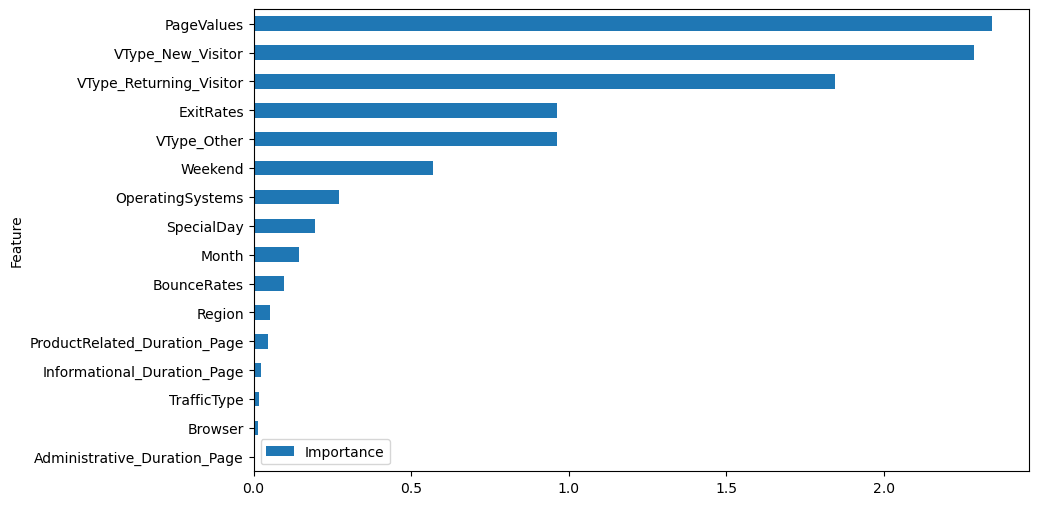

In [139]:
coefficients = best_log_grid.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train_smote.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

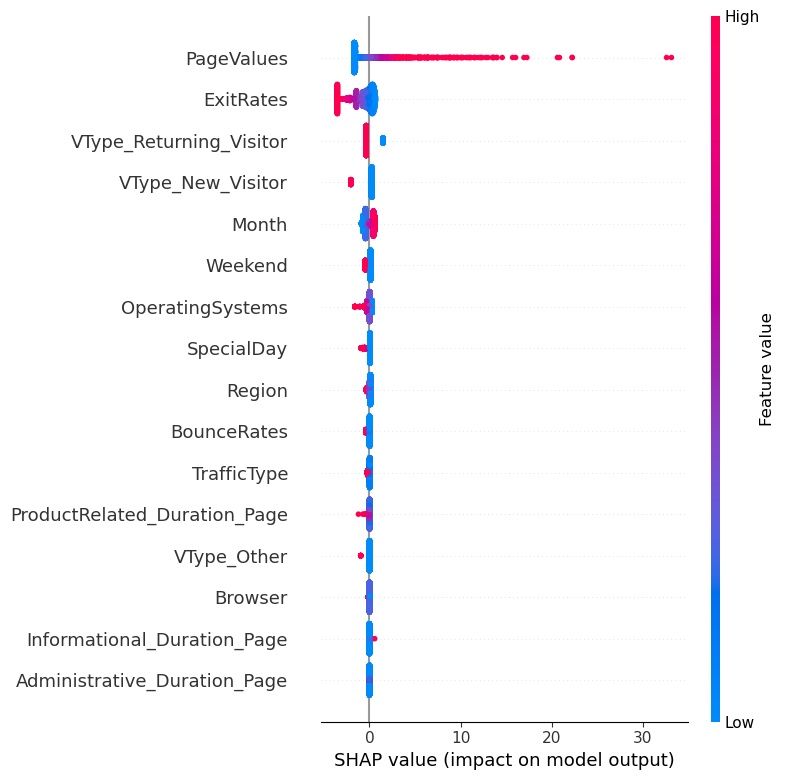

In [140]:
explainer = shap.LinearExplainer(best_log_grid, X_train_smote)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


## KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
knn = KNeighborsClassifier()
knn.fit(X_train_smote, y_train_smote)
eval_(knn)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.78
Precision Score (Train set):0.87
Precision Score (Test set):0.36
Recall Score (Train set):0.98
Recall Score (Test set):0.67
F1 Score (Train set):0.92
F1 Score (Test set):0.47
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.80
Confusion Matrix:
  [[6108 1073]
 [ 144 7037]]


In [57]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### KNN-hyperparameter tuning

In [162]:
param_grid={'n_neighbors': [5,20,50],
            'p' : [1,2],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
           }

In [163]:
knn1=KNeighborsClassifier()

In [164]:
knn_grid = GridSearchCV(knn1, param_grid = param_grid, cv = 3,scoring='roc_auc')

In [165]:
score=knn_grid.fit(X_train_smote,y_train_smote)

In [166]:
score.best_params_

{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}

In [167]:
best_knn_grid=score.best_estimator_

In [168]:
eval_(best_knn_grid)

Accuracy Score(Train set): 0.93
Accuracy Score(Test set): 0.80
Precision Score (Train set):0.89
Precision Score (Test set):0.39
Recall Score (Train set):0.99
Recall Score (Test set):0.64
F1 Score (Train set):0.94
F1 Score (Test set):0.49
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.81
Confusion Matrix:
  [[6307  874]
 [ 107 7074]]


In [917]:
#eval(best_knn_grid)
# Accuracy Score(Train set): 0.89
# Accuracy Score(Test set): 0.80
# Precision Score (Train set):0.60
# Precision Score (Test set):0.40
# Recall Score (Train set):0.96
# Recall Score (Test set):0.67
# F1 Score (Train set):0.74
# F1 Score (Test set):0.50
# ROC AUC Score (Train-proba): 0.98
# ROC AUC Score (Test-proba): 0.81
# Confusion Matrix:
#   [[6304  877]
#  [  48 1314]]

Accuracy Score(Train set): 0.89
Accuracy Score(Test set): 0.80
Precision Score (Train set):0.60
Precision Score (Test set):0.40
Recall Score (Train set):0.96
Recall Score (Test set):0.67
F1 Score (Train set):0.74
F1 Score (Test set):0.50
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.81
Confusion Matrix:
  [[6304  877]
 [  48 1314]]


In [925]:
f = lambda x: best_knn_grid.predict_proba(x)[:, 1]
med = X_train_smote.median().values.reshape((1, X_train_smote.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test.iloc[0:1000, :])
shap.plots.beeswarm(shap_values)

PermutationExplainer explainer:   7%|▋         | 71/1000 [03:08<41:44,  2.70s/it]


KeyboardInterrupt: 

## Random forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
rf = RandomForestClassifier()
rf.fit(X_train_smote, y_train_smote)
eval_(rf)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.87
Precision Score (Train set):1.00
Precision Score (Test set):0.56
Recall Score (Train set):1.00
Recall Score (Test set):0.76
F1 Score (Train set):1.00
F1 Score (Test set):0.65
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[7181    0]
 [   0 7181]]


In [68]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Random Forest- Hyperparameter tuning

In [176]:
rf_param_grid = {'n_estimators': [50,100,150], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['None','sqrt', 'log2'],
                  'max_depth' :[5,6,10],
#                   'min_samples_split': [2,10],
                  'min_samples_leaf' : [7,10] ,} 

In [177]:
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, cv = 3,scoring='roc_auc')

In [178]:
score=rf_grid.fit(X_train_smote,y_train_smote)

In [179]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'n_estimators': 150}

In [180]:
best_rf_grid=score.best_estimator_

In [181]:
eval_(best_rf_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.54
Recall Score (Train set):0.92
Recall Score (Test set):0.80
F1 Score (Train set):0.91
F1 Score (Test set):0.65
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6433  748]
 [ 588 6593]]


In [1006]:
# eval(best_rf_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.63
Precision Score (Test set):0.54
Recall Score (Train set):0.84
Recall Score (Test set):0.79
F1 Score (Train set):0.72
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6510  671]
 [ 224 1138]]


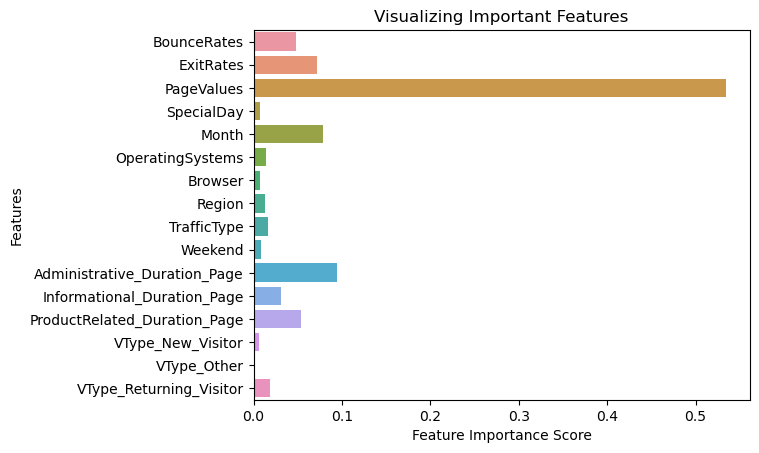

In [75]:
feature_imp1 = best_rf_grid.feature_importances_

sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Decision tree

In [76]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
dt = DecisionTreeClassifier()
dt.fit(X_train_smote, y_train_smote)
eval_(dt)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.85
Precision Score (Train set):1.00
Precision Score (Test set):0.50
Recall Score (Train set):1.00
Recall Score (Test set):0.65
F1 Score (Train set):1.00
F1 Score (Test set):0.56
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.77
Confusion Matrix:
  [[7181    0]
 [   0 7181]]


#### Decision tree-Hyperparameter tuning

In [200]:
dt_param_grid={
    'max_depth' :[5,6,10],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [2, 7] ,
    'max_features' : ['auto', 'sqrt'],
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random']
}

In [201]:
dt = DecisionTreeClassifier(random_state = 42)
dt_grid = GridSearchCV(dt, param_grid = dt_param_grid, cv = 3,scoring='roc_auc')

In [202]:
score=dt_grid.fit(X_train_smote,y_train_smote)

In [203]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'splitter': 'best'}

In [204]:
best_dt_grid=score.best_estimator_

In [205]:
eval_(best_dt_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.89
Precision Score (Test set):0.52
Recall Score (Train set):0.90
Recall Score (Test set):0.78
F1 Score (Train set):0.90
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6408  773]
 [ 732 6449]]


In [1015]:
#eval(best_dt_grid)

Accuracy Score(Train set): 0.89
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.61
Precision Score (Test set):0.52
Recall Score (Train set):0.80
Recall Score (Test set):0.75
F1 Score (Train set):0.69
F1 Score (Test set):0.62
ROC AUC Score (Train-proba): 0.93
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6483  698]
 [ 269 1093]]


## AdaBoost

In [207]:
from sklearn.ensemble import AdaBoostClassifier

In [208]:
ab = AdaBoostClassifier()
ab.fit(X_train_smote, y_train_smote)
eval_(ab)

Accuracy Score(Train set): 0.89
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.55
Recall Score (Train set):0.89
Recall Score (Test set):0.77
F1 Score (Train set):0.89
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.95
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6428  753]
 [ 760 6421]]


In [211]:
ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

#### AdaBoost - Hyperparameter Tuning -without base estimator

In [212]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,300],   
}

In [213]:
ab = AdaBoostClassifier(random_state=42)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [214]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [215]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 100}

In [216]:
best_ab_grid=score.best_estimator_

In [218]:
eval_(best_ab_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.55
Recall Score (Train set):0.90
Recall Score (Test set):0.75
F1 Score (Train set):0.90
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6451  730]
 [ 722 6459]]


In [1168]:
#eval(best_ab_grid)

Accuracy Score(Train set): 0.88
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.59
Precision Score (Test set):0.55
Recall Score (Train set):0.77
Recall Score (Test set):0.75
F1 Score (Train set):0.67
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.92
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[6458  723]
 [ 308 1054]]


#### AdaBoost - Hyperparameter Tuning -with base estimator

In [94]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200]
}

In [95]:
dt_ada = DecisionTreeClassifier(random_state = 42)
ab = AdaBoostClassifier(random_state=42,estimator=dt_ada)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [96]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [97]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.001, 'n_estimators': 50}

In [98]:
best_ab_grid=score.best_estimator_

In [99]:
eval_(best_ab_grid)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.84
Precision Score (Train set):1.00
Precision Score (Test set):0.48
Recall Score (Train set):1.00
Recall Score (Test set):0.64
F1 Score (Train set):1.00
F1 Score (Test set):0.55
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.76
Confusion Matrix:
  [[7181    0]
 [   0 7181]]


## Gradient Boosting


In [219]:
from sklearn.ensemble import GradientBoostingClassifier

In [101]:
gb = GradientBoostingClassifier()
gb.fit(X_train_smote, y_train_smote)
eval_(gb)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.54
Recall Score (Train set):0.92
Recall Score (Test set):0.79
F1 Score (Train set):0.91
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6426  755]
 [ 582 6599]]


#### Gradient Boosting - Hyperparameter Tuning

In [102]:
gb_param_grid={
    'n_estimators':[50,100,150],
    'max_depth':[6],
    'max_features':['log2','sqrt',None],
    #'min_samples_leaf': [2],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6]
    
}

In [103]:
gb= GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, cv = 3,scoring='roc_auc')

In [104]:
score=gb_grid.fit(X_train_smote,y_train_smote)

In [105]:
score.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 150,
 'subsample': 0.6}

In [106]:
best_gb_grid=score.best_estimator_

In [107]:
eval_(best_gb_grid)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.94
Precision Score (Test set):0.55
Recall Score (Train set):0.97
Recall Score (Test set):0.76
F1 Score (Train set):0.96
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6775  406]
 [ 218 6963]]


In [1156]:
eval(best_gb_grid)

Accuracy Score(Train set): 0.93
Accuracy Score(Test set): 0.88
Precision Score (Train set):0.75
Precision Score (Test set):0.56
Recall Score (Train set):0.89
Recall Score (Test set):0.76
F1 Score (Train set):0.81
F1 Score (Test set):0.65
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6765  416]
 [ 144 1218]]


## XGBoost 

In [108]:
from xgboost import XGBClassifier

In [109]:
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)
eval_(xgb)

Accuracy Score(Train set): 0.98
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.97
Precision Score (Test set):0.56
Recall Score (Train set):0.98
Recall Score (Test set):0.75
F1 Score (Train set):0.98
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6985  196]
 [ 113 7068]]


#### XGBoost - Hyperparameter Tuning

In [110]:
xgb_param_grid={
    'max_depth':[5,6,7],
    'gamma':[0,1,2],
    'min_child_weight':[50,100],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6,0.7]
    
}

In [111]:
xgb= XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, cv = 3,scoring='roc_auc')

In [112]:
score=xgb_grid.fit(X_train_smote,y_train_smote)

In [113]:
score.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 50,
 'subsample': 0.7}

In [114]:
best_xgb_grid=score.best_estimator_

In [115]:
eval_(best_gb_grid)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.94
Precision Score (Test set):0.55
Recall Score (Train set):0.97
Recall Score (Test set):0.76
F1 Score (Train set):0.96
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6775  406]
 [ 218 6963]]


In [75]:
# eval(best_xgb_grid)

Accuracy Score(Train set): 0.88
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.59
Precision Score (Test set):0.55
Recall Score (Train set):0.82
Recall Score (Test set):0.81
F1 Score (Train set):0.69
F1 Score (Test set):0.65
ROC AUC Score (Train-proba): 0.94
ROC AUC Score (Test-proba): 0.93
Confusion Matrix:
  [[6410  771]
 [ 241 1121]]


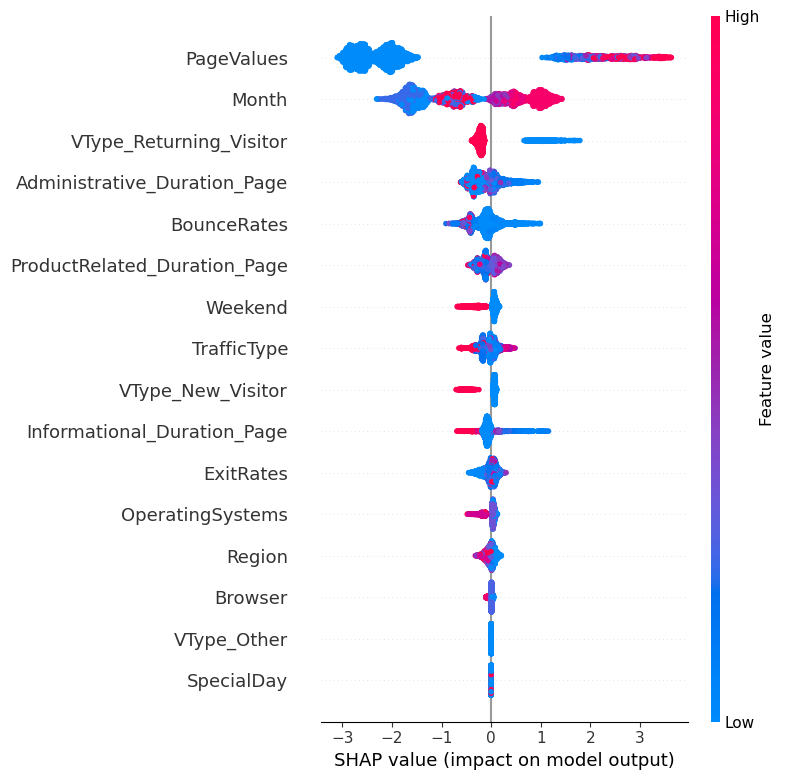

In [116]:
explainer = shap.TreeExplainer(best_xgb_grid)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## Feature selection

In [117]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier

In [118]:
rfe=RFECV(estimator=ExtraTreesClassifier(),step=1,cv=3)

In [119]:
model=rfe.fit(X_train_smote,y_train_smote)

In [120]:
X_train_smote.columns[(model.get_support())]

Index(['BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems',
       'Browser', 'Region', 'TrafficType', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'VType_New_Visitor', 'VType_Returning_Visitor'],
      dtype='object')

In [121]:
selCols=['BounceRates', 'ExitRates', 'PageValues','Month', 'OperatingSystems',
       'Browser', 'Region', 'TrafficType','Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'VType_New_Visitor', 'VType_Returning_Visitor']



In [122]:
X_train_smote_new=X_train_smote[selCols].copy()

In [123]:
y_train_smote.shape

(14362,)

### Gradient Boosting with features selected

In [234]:
# {'learning_rate': 0.1,
#  'max_depth': 6,
#  'max_features': 'log2',
#  'n_estimators': 150,
#  'subsample': 0.6}
gbm= GradientBoostingClassifier(random_state=42,learning_rate=0.1,max_depth= 6,max_features='log2',n_estimators=150,
subsample=0.6)

In [235]:
X_test_new=X_test[selCols].copy()

In [236]:
X_test_new.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems',
       'Browser', 'Region', 'TrafficType', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'VType_New_Visitor', 'VType_Returning_Visitor'],
      dtype='object')

In [237]:
X_test_new.shape

(3662, 13)

In [238]:
gbm.fit(X_train_smote_new,y_train_smote)


GradientBoostingClassifier(max_depth=6, max_features='log2', n_estimators=150,
                           random_state=42, subsample=0.6)

In [239]:
def evalNew(model):
    y_pred=model.predict(X_test_new)
    y_pred_train=model.predict(X_train_smote_new)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test_new)
    y_pred_proba_train = model.predict_proba(X_train_smote_new)
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train[:,1]))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba[:,1]))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [240]:
evalNew(gbm)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.94
Precision Score (Test set):0.55
Recall Score (Train set):0.97
Recall Score (Test set):0.76
F1 Score (Train set):0.96
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6775  406]
 [ 231 6950]]


### XGBoosting with feature selected

In [243]:
xgm= XGBClassifier(random_state=42,learning_rate=0.1,max_depth= 6,subsample=0.7,min_child_weight=50)

In [244]:
xgm.fit(X_train_smote_new,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [245]:
evalNew(xgm)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.89
Precision Score (Test set):0.54
Recall Score (Train set):0.93
Recall Score (Test set):0.81
F1 Score (Train set):0.91
F1 Score (Test set):0.65
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.93
Confusion Matrix:
  [[6361  820]
 [ 504 6677]]


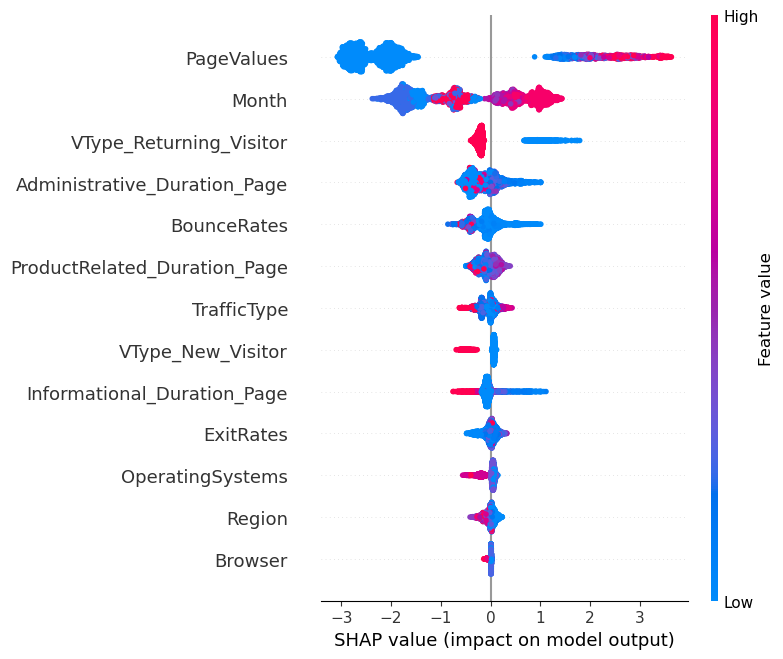

In [246]:
explainer = shap.TreeExplainer(xgm)
shap_values = explainer.shap_values(X_test_new)
shap.summary_plot(shap_values, X_test_new)

### Random Forest with features selected

In [274]:
rfm= RandomForestClassifier(random_state=42,criterion='entropy',max_depth= 10,max_features='sqrt',min_samples_leaf=7,n_estimators=150)

In [275]:
rfm.fit(X_train_smote_new,y_train_smote)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=7,
                       n_estimators=150, random_state=42)

In [276]:
evalNew(rfm)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.54
Recall Score (Train set):0.92
Recall Score (Test set):0.80
F1 Score (Train set):0.91
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6428  753]
 [ 557 6624]]


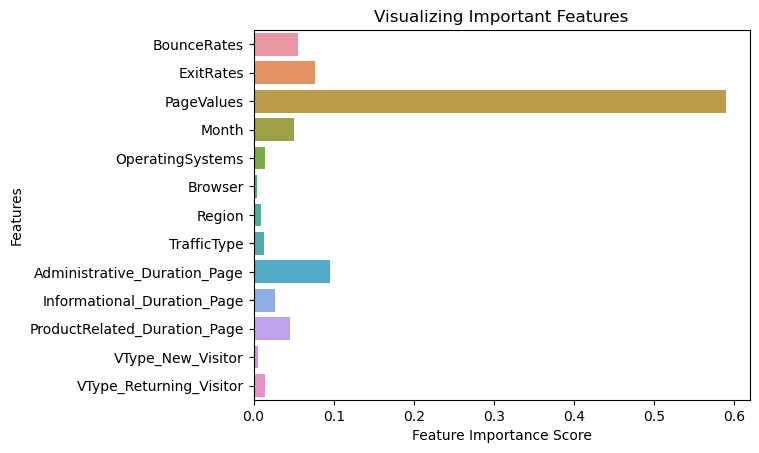

In [251]:
feature_imp1 = rfm.feature_importances_

sns.barplot(x=feature_imp1, y=X_test_new.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [290]:
##learning curve

# train_sizes, train_scores, test_scores = learning_curve(
#     estimator = rfm,
#     X = X_train_smote_new,
#     y = y_train_smote,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     cv = 5,
#     scoring = 'roc_auc')


# y_pred_train_proba = rfm.predict_proba(X_train_smote_new)
# train_scores = roc_auc_score(y_train_smote, y_pred_train_proba[:,1])


# y_pred_proba = rfm.predict_proba(X_test_new)
# test_scores = roc_auc_score(y_test, y_pred_proba[:,1])

# plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
# plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
# plt.xlabel('Training examples')
# plt.ylabel('ROC AUC Score')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()
